Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


[*********************100%***********************]  1 of 1 completed

Price                       Date       Close
Ticker                                   SPY
0      2020-01-02 00:00:00+00:00  324.869995
1      2020-01-03 00:00:00+00:00  322.410004
2      2020-01-06 00:00:00+00:00  323.640015
3      2020-01-07 00:00:00+00:00  322.730011
4      2020-01-08 00:00:00+00:00  324.450012
Price                       Date       Close
Ticker                                   SPY
1228   2024-11-18 00:00:00+00:00  588.150024
1229   2024-11-19 00:00:00+00:00  590.299988
1230   2024-11-20 00:00:00+00:00  590.500000
1231   2024-11-21 00:00:00+00:00  593.669983
1232   2024-11-22 00:00:00+00:00  595.510010


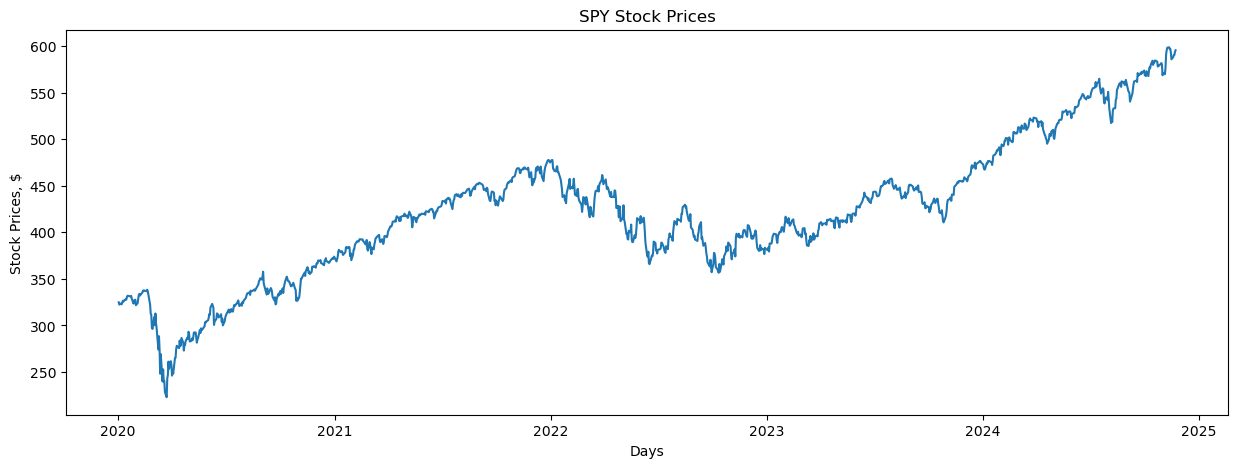

AttributeError: 'DataFrame' object has no attribute 'tolist'

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

# Stock symbol for SPY (SPDR S&P 500 ETF)
stock_name = 'SPY'

# Dates for historical data
start_date = '2020-01-01'
end_date = '2025-11-21'
pred_end_date = '2025-11-21'

# Fetch stock data using yfinance
stock_data = yf.download(stock_name, start=start_date, end=end_date)

# Extract closing prices
S_eon = stock_data[['Close']].reset_index()
print(S_eon.head())
print(S_eon.tail())

# Plot the historical prices
plt.figure(figsize=(15, 5))
plt.plot(S_eon['Date'], S_eon['Close'])
plt.xlabel('Days')
plt.ylabel('Stock Prices, $')
plt.title(f'{stock_name} Stock Prices')
plt.show()

# -------------------------------- GEOMETRIC BROWNIAN MOTION --------------------------------

# Calculate daily returns
returns = S_eon['Close'].pct_change().dropna()
returns_list = returns.tolist()  # Convert to a Python list if needed
print(returns_list)

print(returns.tolist())

# Parameter Assignments
So = S_eon.loc[S_eon.shape[0] - 1, "Close"]
dt = 1  # day
n_of_wkdays = pd.date_range(
    start=pd.to_datetime(end_date, format="%Y-%m-%d") + pd.Timedelta('1 days'),
    end=pd.to_datetime(pred_end_date, format="%Y-%m-%d")
).to_series().map(lambda x: 1 if x.isoweekday() in range(1, 6) else 0).sum()
T = n_of_wkdays  # days
N = T / dt
t = np.arange(1, int(N) + 1)
mu = returns.mean()
sigma = returns.std()
scen_size = 50  # User input
b = {str(scen): np.random.normal(0, 1, int(N)) for scen in range(1, scen_size + 1)}
W = {str(scen): b[str(scen)].cumsum() for scen in range(1, scen_size + 1)}

# Drift and diffusion components
drift = (mu - 0.5 * sigma**2) * t
print(drift)
diffusion = {str(scen): sigma * W[str(scen)] for scen in range(1, scen_size + 1)}
print(diffusion)

# Making the predictions
S = np.array([So * np.exp(drift + diffusion[str(scen)]) for scen in range(1, scen_size + 1)])
S = np.hstack((np.array([[So] for scen in range(scen_size)]), S))  # Add So to the beginning series
print(S)

# Plotting the simulations
plt.figure(figsize=(20, 10))
for i in range(scen_size):
    plt.title(f"Daily Volatility: {sigma}")
    plt.plot(
        pd.date_range(
            start=S_eon["Date"].max(), end=pred_end_date, freq='D'
        ).map(lambda x: x if x.isoweekday() in range(1, 6) else np.nan).dropna(), S[i, :]
    )
    plt.ylabel('Stock Prices, $')
    plt.xlabel('Prediction Days')
plt.show()

# Dataframe format for predictions - first 10 scenarios only
Preds_df = pd.DataFrame(S.swapaxes(0, 1)[:, :10]).set_index(
    pd.date_range(
        start=S_eon["Date"].max(), end=pred_end_date, freq='D'
    ).map(lambda x: x if x.isoweekday() in range(1, 6) else np.nan).dropna()
).reset_index(drop=False)

print(Preds_df.head())
